## 1. Imports

In [1190]:
import glob

import pandas as pd
import geopandas as gpd

from shapely import geometry

import matplotlib.pyplot as plt

import folium
from folium.plugins import HeatMap
from folium.plugins import MarkerCluster
from folium.plugins import MiniMap

from branca.element import Element

## 2. Read data

In [1191]:
glob.glob('*.geojson') # list geojsons = check new data in dir instantly

['design_code_streets.geojson',
 'beaches.geojson',
 'bus_routes.geojson',
 'bus_stops.geojson',
 'design_code_poly.geojson',
 'okn.geojson',
 'poi.geojson']

In [1192]:
okn = gpd.read_file('okn.geojson')
poi = gpd.read_file('poi.geojson')
bus_routes = gpd.read_file("bus_routes.geojson")
bus_stops = gpd.read_file("bus_stops.geojson")
beaches = gpd.read_file("beaches.geojson")
design_code_streets = gpd.read_file("design_code_streets.geojson")

In [1193]:
for i in [okn, poi, bus_routes, bus_stops, beaches, design_code_streets]:
    print(i.crs.name)

WGS 84 / UTM zone 37N
WGS 84 / UTM zone 37N
WGS 84 / UTM zone 37N
WGS 84 / UTM zone 37N
WGS 84 / UTM zone 37N
WGS 84 / UTM zone 37N


## 3. There's a cool design code in Rybinsk downtown

In [1194]:
design_code_streets.head(1)

,fid,id,@id,highway,name,Уровень,geometry
0,6,way/32594141,way/32594141,tertiary,улица Пушкина,2,"LINESTRING (490700.158 6434503.14, 490696.884 ..."


### Get the zone of design-coded streets

In [1195]:
from shapely.ops import linemerge, polygonize, unary_union

In [1196]:
merged_lines = linemerge(unary_union(design_code_streets.geometry))
polygons = list(polygonize(merged_lines))
polygon_design_code = gpd.GeoDataFrame(geometry=polygons, crs=design_code_streets.crs)
dissolved_poly = polygon_design_code.to_crs(epsg=32637).union_all()
buffered_zone = dissolved_poly.buffer(20)
design_code_zone = gpd.GeoDataFrame(geometry=[buffered_zone], crs=32637)

### Preview

<Axes: >

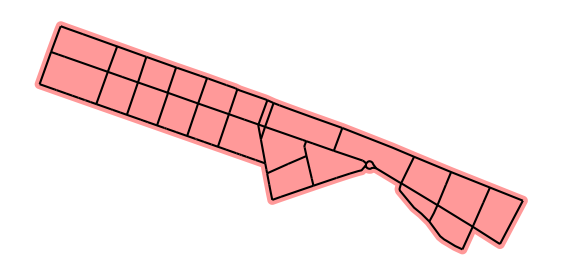

In [1197]:
fig, ax = plt.subplots(figsize=(7,4))

ax.axis('off')

design_code_streets.plot(ax=ax, color='black')
design_code_zone.plot(ax=ax, color='red', alpha=0.4)


## 4. You can swim in Volga (and sometimes use bus to get there)

### Heads preview

In [1198]:
beaches.head(2)

,fid,natural,type,name,geometry
0,1,sand,multipolygon,Петраково,"POLYGON ((462283.349 6435110.011, 462289.119 6..."
1,2,beach,multipolygon,Коприно,"POLYGON ((460251.184 6436434.524, 460253.959 6..."


In [1199]:
bus_stops.head(2)

,fid,name,geometry
0,1,Больница № 4,POINT (480706.192 6439332.092)
1,2,Платформа 4-й километр,POINT (487291.237 6433321.104)


In [1200]:
bus_routes.head(2)

,fid,name,geometry
0,1,Маршрут №158,"MULTILINESTRING ((490265.812 6433426.752, 4902..."
1,2,Маршрут №505,"MULTILINESTRING ((490132.66 6433496.104, 49011..."


### Find the nearest bus stop for each beach

In [1201]:
beaches_points = beaches.centroid
bus_stops = bus_stops

In [1202]:
distance_matrix = beaches_points.geometry.apply(lambda x: bus_stops.distance(x))
distance_matrix['min'] = distance_matrix.min(axis=1)
distance_matrix['min_column'] = distance_matrix.idxmin(axis=1)

In [1203]:
bus_stops['for_beach'] = 0
bus_stops.loc[bus_stops.index.isin(distance_matrix['min_column']), 'for_beach'] = 1
bus_stops.head(2)

,fid,name,geometry,for_beach
0,1,Больница № 4,POINT (480706.192 6439332.092),1
1,2,Платформа 4-й километр,POINT (487291.237 6433321.104),0


### Bus stops preview

/var/folders/kp/3x5xz5491mzf968cwfv_k7ph0000gn/T/ipykernel_16473/731265326.py:3: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  bus_stops.loc[bus_stops['for_beach'] == 0].plot(
/var/folders/kp/3x5xz5491mzf968cwfv_k7ph0000gn/T/ipykernel_16473/731265326.py:11: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  bus_stops.loc[bus_stops['for_beach'] == 1].plot(


<Axes: >

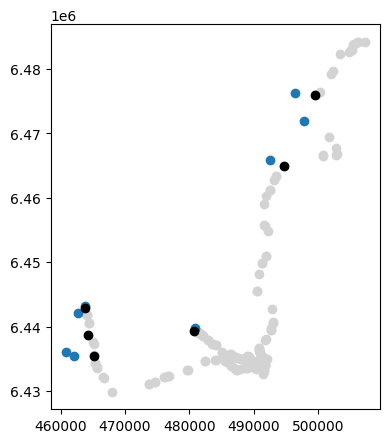

In [1204]:
fig, ax = plt.subplots(figsize=(5,5))

bus_stops.loc[bus_stops['for_beach'] == 0].plot(
    ax=ax,
    color='lightgrey',
    column='for_beach'
)

beaches_points.plot(ax=ax)

bus_stops.loc[bus_stops['for_beach'] == 1].plot(
    ax=ax,
    color='black',
    column='for_beach'
)

### Which beaches are available for a route?

In [1205]:
beaches

,fid,natural,type,name,geometry
0,1,sand,multipolygon,Петраково,"POLYGON ((462283.349 6435110.011, 462289.119 6..."
1,2,beach,multipolygon,Коприно,"POLYGON ((460251.184 6436434.524, 460253.959 6..."
2,3,beach,None,Переборский,"POLYGON ((480681.675 6439949.161, 480713.437 6..."
3,4,beach,multipolygon,Легково,"POLYGON ((463044.479 6442405.333, 463036.042 6..."
4,5,beach,multipolygon,Легково,"POLYGON ((463987.091 6443347.538, 463967.279 6..."
5,6,beach,None,Крестцы,"POLYGON ((497697.956 6472068.241, 497721.676 6..."
6,7,beach,None,Бобарино,"POLYGON ((496266.574 6476677.405, 496189.881 6..."
7,8,beach,None,Григоворо,"POLYGON ((492388.912 6465531.237, 492378.016 6..."


In [1206]:
beaches_gdf = beaches
routes_gdf = bus_routes

# 2. Create a buffer around each route (e.g., 500 meters)
buffer_distance = 2000  # in meters
routes_buffered = routes_gdf.copy()
routes_buffered["geometry"] = routes_buffered.buffer(buffer_distance)

# 3. Spatial join: find beaches within the buffer
joined = gpd.sjoin(beaches_gdf, routes_buffered, how="inner", predicate="intersects")

# 4. Group beach names by route index (from routes_gdf)
beaches_by_route = (
    joined.groupby("index_right")["name_left"]
    .apply(set)
    .rename("beaches")
)

# 5. Attach beach lists to the original routes_gdf
routes_gdf = routes_gdf.join(beaches_by_route, how="left")

# 6. Fill missing (NaN) values with empty lists
routes_gdf["beaches"] = routes_gdf["beaches"].apply(lambda x: x if isinstance(x, set) else [])

In [1207]:
# joined
# routes_gdf

In [1208]:
bus_routes = routes_gdf

In [1209]:
bus_routes

,fid,name,geometry,beaches
0,1,Маршрут №158,"MULTILINESTRING ((490265.812 6433426.752, 4902...",{Легково}
1,2,Маршрут №505,"MULTILINESTRING ((490132.66 6433496.104, 49011...","{Григоворо, Крестцы}"
2,3,Маршрут №3,"MULTILINESTRING ((480707.801 6439345.378, 4807...",{Переборский}


## 5. There're plenty of heritage sites in Rybinsk

In [1210]:
okn.head(2)

,fid,Наименование,Объект,Датировка,Категория,Адрес|улица,Адрес|дом,Адрес|литер,Состояние,Документ,Adress,Latitude,Longitude,geometry
0,1,Дом Тюменевой,Дом Тюменевой,1830-е гг.,выявленный объект,Преображенский пер.,6,None,"удовлетворительное, частично эксплуатируется",Постановление Главы Администрации Ярославской ...,"Ярославская область, город Рыбинск, Преображен...",58.047432,38.855358,POINT (491461.644 6434000.097)
1,2,Дом Казакова,Дом Казакова,1880-е гг.,выявленный объект,Большая Казанская ул.,30,"/ Средняя Казанская, 6","удовлетворительное, эксплуатируется",Постановление Главы Администрации Ярославской ...,"Ярославская область, город Рыбинск, Большая Ка...",58.046476,38.864143,POINT (491980.005 6433892.529)


### make a grid, count heritage sites


In [1211]:
minX, minY, maxX, maxY = okn.total_bounds

d = 200

grid_cells, geom_array = [], []

x, y = minX, minY

while y <= maxY:
    while x <= maxX:
        geom_array.append(geometry.Polygon([(x, y), (x, y+d), (x+d, y+d), (x+d, y), (x, y)]))

        x += d
    
    x = minX
    y += d

grid = gpd.GeoDataFrame(geom_array, columns=['geometry']).set_crs(epsg=32637)
grid['id'] = grid.index

In [1212]:
merged = gpd.sjoin(okn, grid, how='left', predicate='within')
merged['n'] = 1

dissolve = merged.dissolve(by='index_right', aggfunc='count')
grid.loc[dissolve.index, 'n'] = dissolve.n.values

<Axes: >

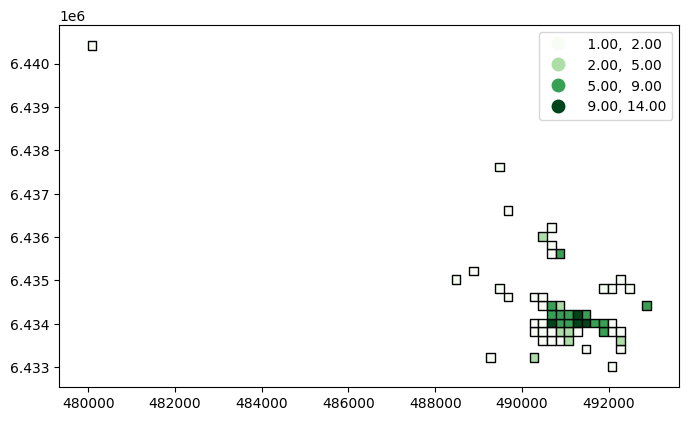

In [1213]:
grid.plot(
    column='n',
    cmap='Greens',
    scheme='natural_breaks',
    figsize=(8,8),
    edgecolor='black', 
    legend=True, 
    k=4
)

## 6. Making map (finally)

**Layers**:
1. Design code
    - the lines of streets + _popup with name by click_
    - the area of design code (built within this notebook)
2. The beaches
    - polygons of beaches + _popup with name by clik_
    - suitable bus stops
    - suitable bus routes + _popup with beaches' names by click_
3. The heritage
    - points of heritage sites + _popup with attributes by click_ **&** _genralization of points during scale change_
    - grid with density of heritage sites
4. POI, relevant for tourists
    - points with the visual difference by the category + _popup with info by clik_
    - heatmap, representing the density of relevant POI in city

### initialize map

In [1214]:
poi_wgs = poi.copy().to_crs(epsg=4326)

master_map = folium.Map(
    location=[poi_wgs.centroid.y.mean(), poi_wgs.centroid.x.mean()], 
    zoom_start=12, 
    tiles='CartoDBVoyager', 
    control_scale=True,
    )

/var/folders/kp/3x5xz5491mzf968cwfv_k7ph0000gn/T/ipykernel_16473/1400043503.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  location=[poi_wgs.centroid.y.mean(), poi_wgs.centroid.x.mean()],


In [1215]:
poi_wgs = poi.copy().to_crs(epsg=4326)

draft_map = folium.Map(
    location=[poi_wgs.centroid.y.mean(), poi_wgs.centroid.x.mean()], 
    zoom_start=12, 
    tiles='CartoDBVoyager', 
    control_scale=True,
    )

/var/folders/kp/3x5xz5491mzf968cwfv_k7ph0000gn/T/ipykernel_16473/1525488360.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  location=[poi_wgs.centroid.y.mean(), poi_wgs.centroid.x.mean()],


### Design code

In [1216]:
design_code = folium.FeatureGroup(name='Дизайн код')

In [1217]:
design_code_zone_wgs = design_code_zone.copy().to_crs(epsg=4326)

geom = design_code_zone_wgs.iloc[0].geometry
coords = [[lat, lon] for lon, lat in geom.exterior.coords]

folium.Polygon(
    locations=coords,
    color='red',
    opacity=0.5,
    fill=True,
    stroke=False
).add_to(design_code)

In [1218]:
design_code_streets_wgs = design_code_streets.copy().to_crs(epsg=4326)



for _, row in design_code_streets_wgs.iterrows():
    geom = row.geometry

    if geom.is_empty:
        continue

    else:
        coords = [[lat, lon] for lon, lat in geom.coords]

    popup_content = f"""
    <strong>Название:</strong> {row['name']}<br>
    <strong>Уровень:</strong> {row['Уровень']}<br>    
    """

    folium.PolyLine(
        coords,
        color='black',
        weight=2,
        popup=folium.Popup(popup_content, max_width=250)
    ).add_to(design_code)

In [1219]:
design_code.add_to(master_map)

### POI

HeatMap of POI

In [1220]:
poi_wgs['lat'] = poi_wgs.geometry.y
poi_wgs['lon'] = poi_wgs.geometry.x

heat_data = poi_wgs[['lat', 'lon']].values.tolist()

gradient = {
    '0.0': '#DDDDDD',
    '0.2': '#D3D4DB',
    '0.4': '#BFC2D8',
    '0.6': '#A6ACD4',
    '0.8': '#838DCF',
    '1.0': '#2539C1'
}

heatmap_layer = folium.FeatureGroup(name='Концентрация POI')

HeatMap(
    heat_data,
    gradient=gradient,
    blur=20
    ).add_to(heatmap_layer)

heatmap_layer.add_to(master_map)

Colourizing POI by category

In [1221]:
category_colors = {
    "Кафе": "#cca817",
    "Ресторан": "#ff7538",
    "Кофейня": "#7d512d",
    "Музей": "#cc3333",
    "Магазин сувениров": "#7b917b",
    "Гостиница": "#6600ff",
    "Default": "grey"
}

Adding points, enabling clustering

In [1222]:
marker_cluster = MarkerCluster(
    name='POI',
    icon_create_function="""
    function(cluster) {
        return L.divIcon({
            html: '<div style="background-color:#2539C1; border: 2px solid #2539C1; border-radius: 20px; width: 25px; height: 25px; display: flex; align-items: center; justify-content: center; color: white; font-weight: bold;">' + cluster.getChildCount() + '</div>',
            className: 'marker-cluster',
            iconSize: [25, 25]
        });
    }
    """
    ).add_to(master_map)

for _, row in poi_wgs.iterrows():
    coord = [row.geometry.y, row.geometry.x]
    cat = row.get("Category", "Default")
    color = category_colors.get(cat)

    # print(coord)

    popup_content = f"""
    <strong>Категория:</strong> {cat}<br>
    <strong>Название:</strong> {row['Name']}<br>
    <strong>Адрес:</strong> {row['Adress']}<br>
    
    """

    folium.CircleMarker(
        location=coord,
        radius=7,
        color=color,
        fill=True,
        stroke=False,
        fill_opacity=0.7,
        popup=folium.Popup(popup_content, max_width=250),
        tags = [cat]
    ).add_to(marker_cluster)

In [1223]:
poi_categories = list(poi['Category'].unique())

### Heritage

In [1224]:
folium.Choropleth(
    geo_data=grid,
    data=grid,
    columns=['id', 'n'],
    fill_color='Greens',
    fill_opacity = 0.75,
    key_on='id',
    nan_fill_opacity=0,
   line_color = "#0000",
   legend_name="Количество ОКН в ячейке",
   name='Плотность ОКН',
   show=False
).add_to(master_map)

In [1225]:
okn_wgs = okn.copy().to_crs(epsg=4326)

okn_marker_cluster = MarkerCluster(
    name='ОКН',
    icon_create_function="""
    function(cluster) {
        return L.divIcon({
            html: '<div style="background-color:#004225; border: 2px solid #004225; border-radius: 20px; width: 30px; height: 30px; display: flex; align-items: center; justify-content: center; color: white; font-weight: bold;">' + cluster.getChildCount() + '</div>',
            className: 'marker-cluster',
            iconSize: [30, 30]
        });
    }
    """
    ).add_to(master_map)

for _, row in okn_wgs.iterrows():
    coord = [row.geometry.y, row.geometry.x]

    popup_content = f"""
    <strong>Наименование</strong>: {row['Наименование']}<br>
    <strong>Период</strong>: {row['Датировка']}<br>
    <strong>Адрес</strong>: {row['Adress']}<br>
    """

    folium.CircleMarker(
        location=coord,
        radius=7,
        fill_color="#004225",
        fill=True,
        stroke=False,
        fill_opacity=1,
        popup=folium.Popup(popup_content, max_width=250)
    ).add_to(okn_marker_cluster)

### Beaches

Reproject

In [1226]:
beaches_wgs = beaches.copy().to_crs(epsg=4326)
bus_stops_wgs = bus_stops.copy().to_crs(epsg=4326)
bus_routes_wgs = bus_routes.copy().to_crs(epsg=4326)

The one group, hidden by default

In [1227]:
beaches_group = folium.FeatureGroup(
    name='Слой для желающих искупаться',
    show = False
)

Bus stops vary by colour on the basis whether they are for beach or not

In [1228]:
bus_stop_colors = {
    1: "#f2c338",
    0: "#AAAAAA"
}

Bus routes

In [1229]:
for _, row in bus_routes_wgs.iterrows():
    geom = row.geometry

    for line in geom.geoms:
        coords = [[lat,lon] for lon, lat in line.coords]

        popup_content = f"""
        <strong>Куда можно доехать:</strong> {', '.join(row['beaches'])} 
        """

        folium.PolyLine(
            coords,
            color="#f2c338",
            weight=2,
            popup=folium.Popup(popup_content, max_width=250)
        ).add_to(beaches_group)


Bus stops

In [1230]:
for _, row in bus_stops_wgs.iterrows():
    coord = [row.geometry.y, row.geometry.x]
    cat = row.get("for_beach", "Default")
    color = bus_stop_colors.get(cat)

    # print(coord)

    popup_content = f"""
    <strong>Название:</strong> {row['name']}<br>
    
    """

    folium.CircleMarker(
        location=coord,
        radius=7,
        color=color,
        fill=True,
        stroke=False,
        fill_opacity=0.7,
        popup=folium.Popup(popup_content, max_width=250)
    ).add_to(beaches_group)

Beaches

In [1231]:
for _, row in beaches_wgs.iterrows():
    geom = row.geometry

    if geom.is_empty:
        continue

    else:
        coords = [[lat, lon] for lon, lat in geom.exterior.coords]

    popup_content = f"""
    <strong>Название:</strong> {row['name']} 
    """

    folium.Polygon(
        coords,
        color='#f2c338',
        popup=folium.Popup(popup_content, max_width=250)
    ).add_to(beaches_group)

In [1232]:
beaches_group.add_to(master_map)

### Features

In [1233]:
folium.LayerControl(collapsed=False).add_to(master_map)

In [1234]:
folium.plugins.Fullscreen(
    position="topright",
    title="Expand me",
    title_cancel="Exit me",
    force_separate_button=True,
).add_to(master_map)

In [1235]:
minimap = MiniMap()
minimap.add_to(master_map)

In [1236]:
TagFilterButton(poi_categories).add_to(master_map)

In [1237]:
html = """
<div style="position: fixed;
     bottom: 10px; right: 10px; z-index:9999;
     background-color: white; padding: 5px;
     border: 1px solid grey; border-radius: 4px;">
  <a href="readme.html" target="_blank" style="text-decoration: none; color: blue;">
    ReadMe
  </a>
</div>
"""

master_map.get_root().html.add_child(Element(html))

### Call and save map

In [1238]:
master_map

In [1239]:
master_map.save('index.html')